In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.utils import resample

In [2]:
def plot_n_images(df, n):
    for i in range(0,n):
        jpg_path=f"Orinoquia_Carma_Traps/orinoquia_camera_traps_images/public/{df.file_name[i]}"
        img = Image.open(jpg_path)
        # Plot it
        print(df.has_animal[i])
        print(df.category_id[i])
        print(df.species[i])
        print(df.seq_num_frames[i])

        plt.imshow(img)
        plt.axis("off")  # Hide axes
        plt.show()

In [3]:
def make_images_anotation_df(file_path):
    # Load your JSON file
    with open(file_path, "r") as f:
        data = json.load(f)
        
    image_annotations_df = pd.DataFrame(data["annotations"])
    images_df = pd.DataFrame(data["images"])
    images_df["category_id"] = image_annotations_df["category_id"]  
    images_df["has_animal"] = images_df["category_id"].apply(lambda x: 0 if x == 0 else 1)
    
    id_to_name = {cat["id"]: cat["name"] for cat in data["categories"]}
    images_df["species"] = images_df["category_id"].map(id_to_name)
    
    return(images_df)

In [4]:
# Load your JSON file
meta_data="Orinoquia_Carma_Traps/metadata/orinoquia_camera_traps.json"
df_metadata=make_images_anotation_df(meta_data)
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112221 entries, 0 to 112220
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              112221 non-null  object
 1   datetime        112221 non-null  object
 2   file_name       112221 non-null  object
 3   seq_id          112221 non-null  object
 4   frame_num       112221 non-null  int64 
 5   seq_num_frames  112221 non-null  int64 
 6   location        112221 non-null  object
 7   category_id     112221 non-null  int64 
 8   has_animal      112221 non-null  int64 
 9   species         112221 non-null  object
dtypes: int64(4), object(6)
memory usage: 8.6+ MB


In [5]:
dropped_rows=[]
for i in range(0, len(df_metadata.file_name)):
    jpg_path=f"Orinoquia_Carma_Traps/orinoquia_camera_traps_images/public/{df_metadata.file_name[i]}"
    if(os.path.exists(jpg_path)):
        continue
    else:
        dropped_rows.append(i)
df_cleaned=df_metadata.drop(dropped_rows)
df_cleaned=df_cleaned.reset_index(drop=True)

In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104780 entries, 0 to 104779
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              104780 non-null  object
 1   datetime        104780 non-null  object
 2   file_name       104780 non-null  object
 3   seq_id          104780 non-null  object
 4   frame_num       104780 non-null  int64 
 5   seq_num_frames  104780 non-null  int64 
 6   location        104780 non-null  object
 7   category_id     104780 non-null  int64 
 8   has_animal      104780 non-null  int64 
 9   species         104780 non-null  object
dtypes: int64(4), object(6)
memory usage: 8.0+ MB


In [7]:
df_cleaned = df_cleaned.sample(frac=1, random_state=44)

In [8]:
df_locations=df_cleaned.groupby(["location","has_animal"]).size().reset_index(name="count")
df_pivot = df_locations.pivot(index='location', columns='has_animal', values='count').fillna(0)

df_pivot['total'] = df_pivot[0] + df_pivot[1]
df_pivot = df_pivot.sort_values('total', ascending=False).drop(columns='total')

In [9]:
df_pivot.head()

has_animal,0,1
location,,
N29,1325,7205
M04,1374,7044
N14,557,4016
M00,660,3738
N25,649,3729


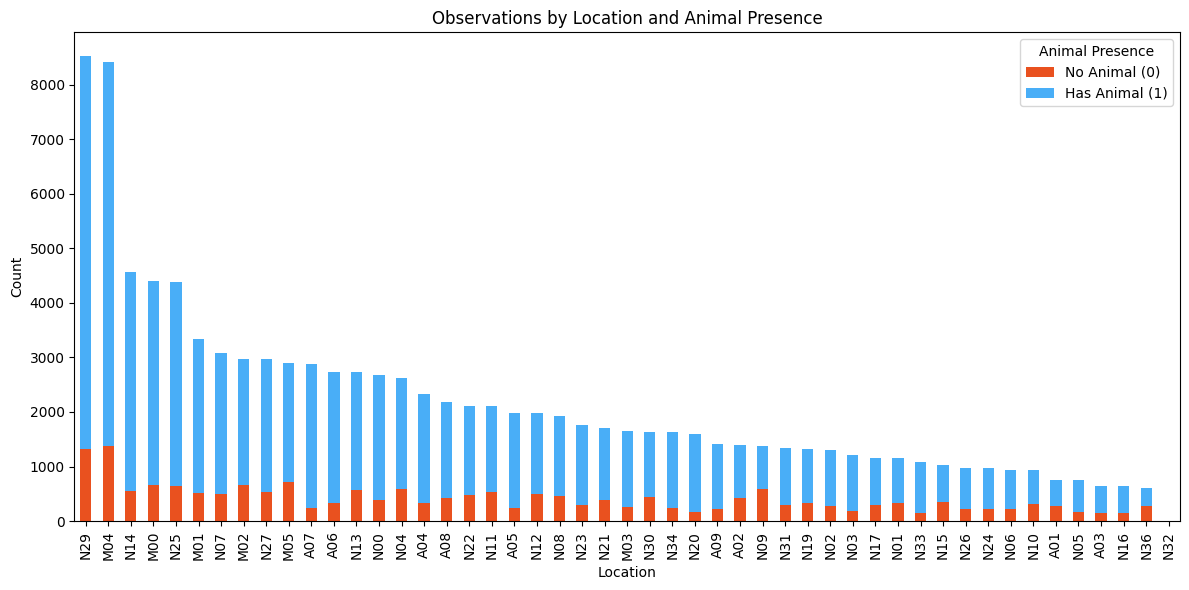

In [10]:
df_pivot.plot(kind='bar', stacked=True, color=["#E9511F", "#49AEF7"], figsize=(12, 6))
# Customize
plt.title("Observations by Location and Animal Presence")
plt.xlabel("Location")
plt.ylabel("Count")
plt.legend(["No Animal (0)", "Has Animal (1)"], title="Animal Presence")
plt.tight_layout()
plt.show()

In [11]:
df_temp=df_cleaned.groupby(["has_animal"]).size().reset_index(name="count")
px.bar(df_temp, x="has_animal", y="count")

In [12]:
# balence the data
df_empty=df_cleaned[df_cleaned.has_animal==0]
df_empty = df_empty.reset_index(drop=True)
df_animal=df_cleaned[df_cleaned.has_animal==1]
df_animal=df_animal.reset_index(drop=True)

In [13]:
df_animal_reduced = resample(df_animal, 
                                 replace=False, 
                                 n_samples=len(df_empty), 
                                 random_state=42)
df_balenced=pd.concat([df_animal_reduced, df_empty])
df_balenced = df_balenced.sample(frac=1, random_state=42)


In [14]:
df_temp=df_balenced.groupby(["has_animal"]).size().reset_index(name="count")
px.bar(df_temp, x="has_animal", y="count")

In [15]:
df_locations=df_balenced.groupby(["location","has_animal"]).size().reset_index(name="count")
df_pivot = df_locations.pivot(index='location', columns='has_animal', values='count').fillna(0)

df_pivot['total'] = df_pivot[0] + df_pivot[1]
df_pivot = df_pivot.sort_values('total', ascending=False).drop(columns='total')

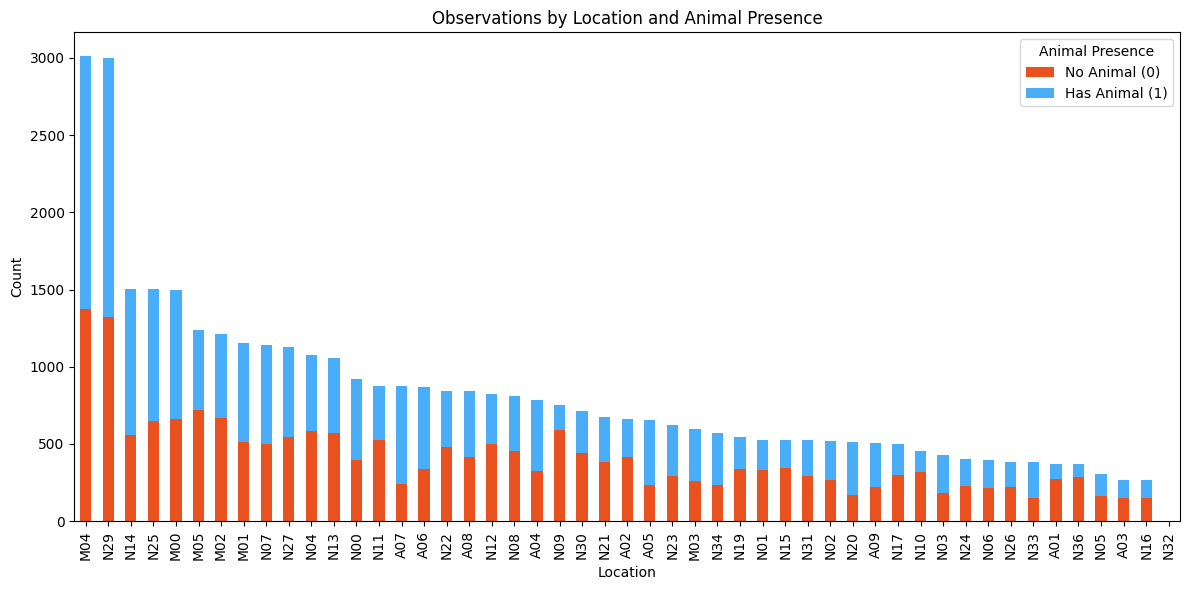

In [16]:
df_pivot.plot(kind='bar', stacked=True, color=["#E9511F", "#49AEF7"], figsize=(12, 6))
# Customize
plt.title("Observations by Location and Animal Presence")
plt.xlabel("Location")
plt.ylabel("Count")
plt.legend(["No Animal (0)", "Has Animal (1)"], title="Animal Presence")
plt.tight_layout()
plt.show()

In [17]:
df_balenced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39588 entries, 33214 to 3955
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              39588 non-null  object
 1   datetime        39588 non-null  object
 2   file_name       39588 non-null  object
 3   seq_id          39588 non-null  object
 4   frame_num       39588 non-null  int64 
 5   seq_num_frames  39588 non-null  int64 
 6   location        39588 non-null  object
 7   category_id     39588 non-null  int64 
 8   has_animal      39588 non-null  int64 
 9   species         39588 non-null  object
dtypes: int64(4), object(6)
memory usage: 3.3+ MB
